In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

In [7]:
def calculate_technical_indicators(df):
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
    
    delta = df['Adj Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()

    return df

In [8]:
stocks_data = {}

In [10]:
for ticker in tickers:
    print(f"Baixando dados para {ticker}...")
    data = yf.download(ticker, start="2017-01-01", end="2023-12-31")
    
    if 'Adj Close' in data.columns:
        data = calculate_technical_indicators(data)
        data.dropna(inplace=True)  
        data[f'{ticker}_lag1'] = data['Adj Close'].shift(1)  
        data.dropna(inplace=True)  
        stocks_data[ticker] = data
    else:
        print(f"Coluna 'Adj Close' não encontrada para {ticker}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Baixando dados para AAPL...
Baixando dados para MSFT...
Baixando dados para GOOGL...
Baixando dados para AMZN...
Baixando dados para META...


In [11]:
print(stocks_data['AAPL'].head())

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2017-03-16  35.180000  35.255001  35.064999  35.172501  32.750877   76928000   
2017-03-17  35.250000  35.250000  34.972500  34.997501  32.587929  175540000   
2017-03-20  35.099998  35.375000  35.057499  35.365002  32.930115   86168000   
2017-03-21  35.527500  35.700001  34.932499  34.959999  32.553005  158119600   
2017-03-22  34.962502  35.400002  34.939999  35.355000  32.920811  103440800   

               SMA_20     SMA_50        RSI     EMA_20  AAPL_lag1  
Date                                                               
2017-03-16  32.189158  30.151475  73.241324  32.004333  32.697338  
2017-03-17  32.243165  30.265405  66.813430  32.059914  32.750877  
2017-03-20  32.309975  30.383444  71.265434  32.142790  32.587929  
2017-03-21  32.346522  30.487915  50.267852  32.181858  32.930115  
2017-03-22  32.396688  30.59473

In [12]:
file_path = '/Users/pedrobueno/Desktop/TCC/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_3403845.csv'
df_pib = pd.read_csv(file_path, sep=';', skiprows=4)

In [13]:
df_pib_filtered = df_pib.loc[:, '2017':'2023']
df_pib_filtered = df_pib_filtered.T.reset_index()
df_pib_filtered.columns = ['Year', 'GDP']
df_pib_filtered['Date'] = pd.to_datetime(df_pib_filtered['Year'] + '-01-01')

In [14]:
df_pib_daily = pd.DataFrame(index=pd.date_range(start="2017-01-01", end="2024-01-01"))
df_pib_daily['GDP'] = np.nan

In [15]:
for i, row in df_pib_filtered.iterrows():
    start_date = row['Date']
    if i < len(df_pib_filtered) - 1:
        end_date = df_pib_filtered.loc[i + 1, 'Date'] - pd.DateOffset(days=1)
    else:
        end_date = pd.to_datetime('2024-01-01')
    
    df_pib_daily.loc[start_date:end_date, 'GDP'] = row['GDP']

In [16]:
print(df_pib_daily.head())

                     GDP
2017-01-01  1.961210e+13
2017-01-02  1.961210e+13
2017-01-03  1.961210e+13
2017-01-04  1.961210e+13
2017-01-05  1.961210e+13


In [17]:
for ticker in tickers:
    stocks_data[ticker] = stocks_data[ticker].join(df_pib_daily['GDP'], how='left')

In [36]:
df_all = pd.DataFrame()

for ticker in tickers:
    data = stocks_data[ticker][['Adj Close', f'{ticker}_lag1', 'GDP', 'SMA_20', 'SMA_50', 'RSI', 'EMA_20']].copy()
    data.columns = [f'{ticker}_{col}' for col in data.columns]  # Renomear colunas com prefixo da ação
    if df_all.empty:
        df_all = data
    else:
        df_all = df_all.join(data, how='inner')
df_all.dropna(inplace=True)

In [37]:
X = df_all[[f'{ticker}_{col}' for ticker in tickers for col in [f'{ticker}_lag1', 'GDP', 'SMA_20', 'SMA_50', 'RSI', 'EMA_20']]]
y = df_all[[f'{ticker}_Adj Close' for ticker in tickers]]

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [40]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [41]:
y_pred = model.predict(X_test)

In [43]:
for i, ticker in enumerate(tickers):
    print(f"\nResultados para {ticker}:")
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")



Resultados para AAPL:
Mean Squared Error: 3.16877127406855
Mean Absolute Error: 1.2484636917437144
R2 Score: 0.9989169859948318

Resultados para MSFT:
Mean Squared Error: 9.322394278607595
Mean Absolute Error: 2.280796472811253
R2 Score: 0.9989171926483879

Resultados para GOOGL:
Mean Squared Error: 2.1307893426154267
Mean Absolute Error: 0.9911042165788148
R2 Score: 0.9980331728355476

Resultados para AMZN:
Mean Squared Error: 6.455139566007028
Mean Absolute Error: 1.722562978124588
R2 Score: 0.9955738164297887

Resultados para META:
Mean Squared Error: 19.465088862977556
Mean Absolute Error: 3.2394698097410592
R2 Score: 0.9956641917554995


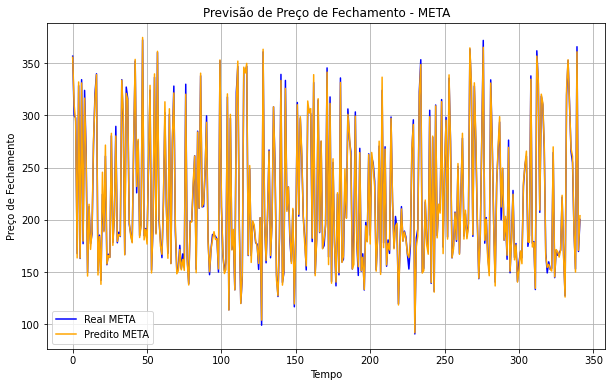

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.iloc[:, i].values, label=f'Real {ticker}', color='blue')
plt.plot(y_pred[:, i], label=f'Predito {ticker}', color='orange')
plt.title(f'Previsão de Preço de Fechamento - {ticker}')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
df_results = pd.DataFrame()

for i, ticker in enumerate(tickers):
    df_results[f'Real_{ticker}'] = y_test.iloc[:, i].values  
    df_results[f'Predito_{ticker}'] = y_pred[:, i]

In [48]:
print(df_results.head())

    Real_AAPL  Predito_AAPL   Real_MSFT  Predito_MSFT  Real_GOOGL  \
0  141.067734    141.127984  287.396973    286.970144  138.689590   
1  174.119003    175.907774  327.759827    335.641296  137.060608   
2  186.870148    187.767748  329.295868    330.177351  116.850662   
3   38.229481     37.303044   67.478157     66.500302   46.671932   
4  140.930069    139.954249  287.445740    284.206531  138.881104   

   Predito_GOOGL   Real_AMZN  Predito_AMZN   Real_META  Predito_META  
0     138.309502  167.181503    167.200992  356.746948    355.667267  
1     138.428324  140.389999    144.743076  299.694153    309.775305  
2     116.756994  128.779999    128.004184  297.678284    293.932434  
3      45.872342   47.702999     45.788395  167.705383    163.481900  
4     136.975140  165.121506    162.738004  328.544861    332.048801  
